In [41]:

import streamlit as st
import pandas as pd
import numpy as np
import requests
import spacy
nlp = spacy.load('de') #load spacy model
import tqdm
from collections import Counter
import collections
import matplotlib.pyplot as plt

import json

import sys
sys.path.append("/Users/seven/data/git/mpileipzig/penelope/components/")


 

In [37]:
# see devStatementGraph and devPaperPipeline for development and documentation
def StatementGraphGenerator(inParams):

    stm_list = inParams['data']
    
    if inParams['language'] == 'en':
        nlp = spacy.load('en_core_web_sm') #load english spacy model
    elif inParams['language'] == 'de':
        nlp = spacy.load('de_core_news_sm') #load german spacy model
    elif inParams['language'] == 'fr':
        nlp = spacy.load('fr_core_news_sm') #load french spacy model
    elif inParams['language'] == 'es':
        nlp = spacy.load('es_core_news_sm') #load spanish spacy model
    elif inParams['language'] == 'pt':
        nlp = spacy.load('pt_core_news_sm') #load portuguese spacy model
    elif inParams['language'] == 'it':
        nlp = spacy.load('it_core_news_sm') #load italian spacy model
    elif inParams['language'] == 'nl':
        nlp = spacy.load('nl_core_news_sm') #load dutch spacy model
    elif inParams['language'] == 'el':
        nlp = spacy.load('el_core_news_sm') #load greek spacy model
    elif inParams['language'] == 'nb':
        nlp = spacy.load('nb_core_news_sm') #load norwegian bokmal spacy model
    elif inParams['language'] == 'lt':
        nlp = spacy.load('lt_core_news_sm') #load lithuanian spacy model
    elif inParams['language'] == 'xx':
        nlp = spacy.load('xx_ent_wiki_sm') #load multi-language spacy model

    else:
        print('ERROR! Language not supported!')
        
    relevantPOS = inParams['pos']
    ignoreLEM = inParams['ignore']
    
    # 1.2.2 Note: requires spacy and language model to be loaded
    print('apply nlp pipeline')
    for value in tqdm.tqdm(stm_list):
        doc = nlp(value['text'])
        value.update({'doc' : doc})
    
    # 1.2.3
    # Data cleaning options
    print('filter words')
    #relevantPOS = ['NOUN','VERB','ADJ']
    #ignoreLEM = ['Herr','Kollege','Dame','Frau','Präsident']
    #ignoreLEM = []

    stm_list_nlp = []
    statements_lemma_list = []
    #statements_pos_list = []
    for stm in tqdm.tqdm(stm_list):
        lemmas = []
        pos = []
        for token in stm['doc']:
            if token.is_punct is not True and token.is_stop is not True and token.pos_ in relevantPOS and token.lemma_ not in ignoreLEM:
                lemmas.append(token.lemma_)
                pos.append(token.pos_)
        stm.update({'lemmata' : lemmas})    
        statements_lemma_list.append(lemmas)
        #statements_pos_list.append(pos)

    # 1.2.4
    print('count and order lemmata')
    flattened = [val for lemmas in statements_lemma_list for val in lemmas]
    lemma_frequency_list = collections.Counter(flattened).most_common()
    all_lemmata_list = [ i[0] for i in lemma_frequency_list ]
    all_lemmata_count = [ i[1] for i in lemma_frequency_list ]

    # remove single items
    # 1.2.5
    print('remove singles')
    all_freq_lemmata_list = [ all_lemmata_list[i] for i,v in enumerate(all_lemmata_list) if (all_lemmata_count[i] > 1) ]
    all_freq_lemmata_count = [ all_lemmata_count[i] for i,v in enumerate(all_lemmata_count) if (all_lemmata_count[i] > 1) ]
        
    all_lemmata_list = all_freq_lemmata_list
    all_lemmata_count = all_freq_lemmata_count 

    # Construct word browsable dict for later use in semantic relatedness computation
    wordscounts_dict = {}
    for lx,lem in enumerate(all_lemmata_list):
        wordscounts_dict.update({ lem : all_lemmata_count[lx] })
 
    # From this file
    stmnet_dict = {
        'nodes' : [],
        'links' : []
        }    
 

    for ix,stm in enumerate(stm_list):
        if len(stm['lemmata']) > 0:
            node_dict = {
                'id' : ix+1
            }
            for ele in stm:
                if ele != 'lemmata' and ele != 'doc':
                    node_dict.update({ele : stm[ele]})
            
            mfic = [ lem for lem in all_lemmata_list if (lem in stm['lemmata'] )]
            #freqI = collections.Counter(stmI).most_common()
            #lemmataI = [ i[0] for i in freqI ]
            if len(mfic)>0:
                node_dict.update({'mfic' : mfic[0]})
            else:
                node_dict.update({'mfic' : ' '})
    
            stmnet_dict['nodes'].append(node_dict)
    
    
    #stmnet_dict['graph']['edges'] = []
    for nodeI in tqdm.tqdm(stmnet_dict['nodes']):
        stmI = stm_list[ nodeI['id']-1 ]['lemmata']
        for nodeJ in stmnet_dict['nodes']:     
            if nodeI['id'] < nodeJ['id']:
                stmJ = stm_list[ nodeJ['id']-1 ]['lemmata']
                overlap = [ lem for lem in set(stmI) if (lem in set(stmJ))]  # set overlap
                weight = len(overlap) / (len(stmI)+len(stmJ))
                if (len(overlap) > 0):
                    edge_dict = {
                        'source' : nodeI['id'],
                        'target' : nodeJ['id'],
                        'weight' : weight
                        }
                    stmnet_dict['links'].append(edge_dict)
    
    return stmnet_dict

In [52]:
#search_query = "Digitalisierung"
#search_query = "Klima"
#search_query = "Sozialismus"
#search_query = "Kräfte"

#search_query = "erneuerbar"
#search_query2 = "wirtschaftlich"

search_query = "Afrika"
search_query2 = "Europa"

json = {'search_query':search_query, 
        'dataset_name':'deu', 
        'start_date':'2016-1-1', 
        'end_date':'2021-1-1'}
result = requests.post('https://penelope.vub.be/parliament-data/get-speeches', json=json)



In [53]:
speeches = []
for speech in result.json()["speeches"]:
    speeches.append(speech)
    #parties.append(speech['party'])
    #print(speech['date'])

# code to sort list on date 
speeches.sort(key = lambda x:x['date'])    

In [54]:
json = {'search_query':search_query2, 
        'dataset_name':'deu', 
        'start_date':'2016-1-1', 
        'end_date':'2021-1-1'}
result = requests.post('https://penelope.vub.be/parliament-data/get-speeches', json=json)

speeches2 = []
for speech in result.json()["speeches"]:
    speeches2.append(speech)

# code to sort list on date 
speeches2.sort(key = lambda x:x['date']) 

In [55]:
jointspeeches=[]
for speech in speeches:
    if search_query in speech['text'] and search_query2 in speech['text']:
        jointspeeches.append(speech)
ljoint = len(jointspeeches)
print(f"There are {ljoint} speeches containing _{search_query}_ and _{search_query2}_")

There are 220 speeches containing _Afrika_ and _Europa_


In [ ]:
stm_list=[]
for speech in tqdm.tqdm(jointspeeches):
    doc = nlp(speech["text"])
    for sent in doc.sents:
        if search_query in sent.text and search_query2 in sent.text:
            #print(sent)
            stm_dict = {
                'name'  : speech["name"],
                'party' : speech["party"],
                'text'  : sent.text
            }
            stm_list.append(stm_dict)
stm_list            

In [33]:
stm_list=[]
for speech in tqdm.tqdm(jointspeeches):
    doc = nlp(speech["text"])
    if search_query in speech["text"] and search_query2 in speech["text"]:
        #print(sent)
        stm_dict = {
            'name'  : speech["name"],
            'party' : speech["party"],
            'text'  : speech["text"],
            'length' : len(speech['text'])
        }
        stm_list.append(stm_dict)
stm_list[0]

100%|██████████| 95/95 [00:07<00:00, 12.51it/s]


In [34]:
stm_list[0]

{'name': 'Andreas Lenz',
 'party': 'CDU/CSU',
 'text': 'Sehr geehrte Frau Präsidentin, für die CDU/CSU-Fraktion natürlich, auch wenn ich Sie ungern korrigiere. – Sehr geehrte Damen und Herren! Liebe Kolleginnen und Kollegen! Der deutsche Arbeitsmarkt steht so gut da wie noch nie in der Geschichte der Bundesrepublik. So erreichte die Zahl der Erwerbstätigen im September dieses Jahres mit 44,5 Millionen Menschen in Beschäftigung einen erneuten Höchststand. Das sind 600 000 Menschen mehr als zu diesem Zeitpunkt im letzten Jahr. Dieser wirtschaftliche Erfolg hat auch einen Namen: Das ist die unionsgeführte Bundesregierung. – In Bayern läuft es natürlich noch besser, Kollege Ernst. – Aber gleichzeitig merkt man bei einem geplanten Stellenabbau wie jetzt bei Siemens einmal mehr, dass die gute wirtschaftliche Situation nicht gottgegeben ist. Wir stehen als Wirtschaftsstandort im internationalen Wettbewerb und sind durch unsere Exportorientierung auf die Weltmärkte angewiesen wie kaum ein ande

In [45]:
parties = []

dates = []
for speech in speeches:
    parties.append(speech['party'])
    dates.append(speech['date'])
    #print(speech['date'],speech['party'])

In [54]:
# Create an empty dataframe
df = pd.DataFrame()

# Create a column from the datetime variable
df['datetime'] = dates
# Convert that column into a datetime datatype
df['datetime'] = pd.to_datetime(df['datetime'])
# Set the datetime column as the index
df.index = df['datetime'] 
# Create a column from the numeric score variable
df['party'] = parties

In [56]:
df

,datetime,party
datetime,,
2017-10-24,2017-10-24,CDU/CSU
2017-11-21,2017-11-21,CDU/CSU
2017-11-21,2017-11-21,CDU/CSU
2017-11-21,2017-11-21,CDU/CSU
2017-11-22,2017-11-22,CDU/CSU
...,...,...
2019-11-15,2019-11-15,DIE LINKE
2019-11-15,2019-11-15,CDU/CSU
2019-11-15,2019-11-15,BÜNDNIS 90/DIE GRÜNEN


In [65]:
# Group the data frame by month and item and extract a number of stats from each group
total = df.resample('M').agg({'party':'count'})
#total

In [67]:
total/total

,party
datetime,
2017-10-31,1.0
2017-11-30,1.0
2017-12-31,1.0
2018-01-31,1.0
2018-02-28,1.0
2018-03-31,1.0
2018-04-30,1.0
2018-05-31,1.0
2018-06-30,1.0


In [28]:
print(len(speeches))
partycounts = dict(Counter(parties).most_common())
partycounts

1040


{'CDU/CSU': 400,
 'SPD': 205,
 'FDP': 167,
 'BÜNDNIS 90/DIE GRÜNEN': 92,
 'AfD': 87,
 'DIE LINKE': 58,
 'BÜNDNIS\xa090/DIE GRÜNEN': 23,
 'fraktionslos': 8}

In [19]:
speeches[10]

{'date': '2018-02-22',
 'discussion_title': 'Tagesordnungspunkt 7 2018-02-22',
 'id': 'ID191404500',
 'name': 'Anja Weisgerber',
 'party': 'CDU/CSU',
 'period': '19',
 'text': 'Sehr geehrte Frau Präsidentin! Werte Kolleginnen und Kollegen! Klimaschutz ist eine große Herausforderung. Er ist wichtig, für manche Inseln im Pazifik ist er eine Überlebensfrage. Aber auch bei uns in Deutschland sind die Auswirkungen des Klimawandels bereits spürbar. Die Entwicklung von Innovationen im Bereich Klimaschutz ist eine Riesenchance für die Wirtschaft. Wir müssen am Ball bleiben. Wir müssen den Wandel gestalten. Wir dürfen ihn nicht verschlafen. Ich war gestern im Umweltministerium, wo der Deutsche Innovationspreis für Klima und Umwelt an mutige Unternehmer verliehen wurde. Auch mir machte diese Veranstaltung Mut, weil ich gesehen habe, mit welcher Kraft und mit welcher Überzeugung die Unternehmer bei der Sache sind. Es wurden tolle Projekte vorgestellt. Zum Beispiel kann Papier aus Gras hergestellt

In [177]:
stm_list=[]
for speech in tqdm.tqdm(speeches):
    doc = nlp(speech["text"])
    for sent in doc.sents:
        if search_query in sent.text:
            #print(sent)
            stm_dict = {
                'name'  : speech["name"],
                'party' : speech["party"],
                'text'  : sent.text
            }
            stm_list.append(stm_dict)
    
len(stm_list)
    

100%|██████████| 851/851 [00:57<00:00, 14.69it/s]


236

In [178]:
#for ele in stm_list:
#    print(ele)

In [57]:

inParams = {
    'data': stm_list,
    'language' : "de",
    #'pos' : ['NOUN','VERB','ADJ'],
    'pos' : ['NOUN'],
    'ignore' : [search_query,search_query2]
}

graph = StatementGraphGenerator(inParams)

 15%|█▌        | 12/80 [00:00<00:00, 116.80it/s]

apply nlp pipeline


100%|██████████| 79/79 [00:00<00:00, 10056.15it/s]

filter words
count and order lemmata
remove singles


236 79


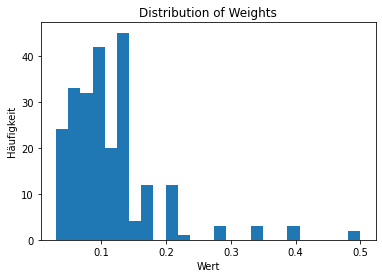

In [58]:

print(len(graph['links']),
len(graph['nodes']))

weights=[]
for link in graph['links']:
    weights.append(link['weight'])

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()
#print(graph['nodes'])
#graph['links']


In [63]:
newlinks = []
for link in graph['links']:
    if link['weight'] > 0.07:
        newlinks.append(link)
graph['links'] = newlinks    
print(len(graph['links']),
len(graph['nodes']))

179 79


In [64]:
json = {'data':graph, 
        'nodecoloring':'party', 
        'nodelabel': 'text', 
        "darkmode": False,
        "edgevisibility": True,
        "particles": False
       }
result = requests.post('https://penelope.vub.be/network-components/visualiser', json=json)

In [65]:
with open ("./satzgraph.html", "w") as f:
    f.write(result.json()['graph'])

### Check: Das funktioniert irgendwie nicht!

In [181]:
#stm_list =[{'text': 'Das war ein Satz.'},
#           {'text': 'Der Satz des Tages ist das.'} 
#]

json = {'data':stm_list, 
        'language':'de', 
        'ignore': ['Digitalisierung'], 
        #"relevant_pos": ["VERB","NOUN","ADJ"]
        "relevant_pos": ["NOUN"]
       }
result = requests.post('https://penelope.vub.be/network-components/statementgraphgenerator', json=json)

TypeError: Object of type Doc is not JSON serializable

In [111]:
graph = result.json()
print(len(graph['links']),
len(graph['nodes']))
print(graph['nodes'])
graph['links']

0 2
[{'id': 1, 'mfic': '', 'text': 'Das war ein Satz.'}, {'id': 2, 'mfic': '', 'text': 'Der Satz des Tages ist das.'}]


[]